## Study the dependency on the error

In this case we have delete the nodes without connections

In [1]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict
from itertools import permutations

### DataSet and Group information

In [2]:
with open("def_Celegans_2syn_layers_219_cluster.pkl", 'rb') as file:
    Celegans_syn_layers = pickle.load(file)

K = 2
dic_A = Celegans_syn_layers
probs = list(dic_A.keys())
print(probs)
N_probs = len(probs)
N_reps = dic_A[probs[0]].shape[0]
start_groups = np.array([0,65,109,151,180,212])
end_groups = np.array([65,109,151,180,212,219])
n_groups = len(start_groups)

Nx = len(dic_A[probs[0]][0,0,0,:])
print('N_probs, N_reps', N_probs, N_reps)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
N_probs, N_reps 7 10


## Functions

In [3]:
@jit(nopython=True)
def overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2,A_f, P_inv_old, i_change, j_change,pp1, pp2): 

    Nx = L_f_v1v2_old.shape[1]
    K = A_f.shape[0]
    
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
  
    #old and new: changes and mapping changes
    changes = np.array([i_change, j_change], dtype = np.int32)
    changes_p = np.array([pp1, pp2], dtype = np.int32)  
    changes_old = np.array([j_change, i_change], dtype = np.int32)
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)
    
    for i_k in range(K):
        for i_chan,change in enumerate(changes):
            for i_x in range(Nx):
                if (i_k != m1): # Only changes in the networks m1
                    p_f = int(P_inv_old[i_k,change])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                
                else:
                    p_f = changes_p[i_chan]
                    p_old = changes_p_old[i_chan]
                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else: # Only changes in the nodes i,j
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c

                ## rows
                valor_L_old, valor_A_old = L_f_v1v2_old[i_chan,i_x], A_f[i_k,p_old,p_old_c]   
                valor_L_new, valor_A_new = L_f_v1v2[i_chan,i_x], A_f[i_k,p_f,p_c]
                ## columns
                valor_L_old_c, valor_A_old_c = 0,0
                valor_L_new_c, valor_A_new_c = 0,0
                column = 0        
                if (i_x not in changes):
                    column = 1
                    valor_L_old_c, valor_A_old_c = L_c_v1v2_old[i_chan,i_x],A_f[i_k,p_old_c, p_old]
                    valor_L_new_c, valor_A_new_c = L_c_v1v2[i_chan,i_x], A_f[i_k,p_c,p_f]

                ovlp_1_old = ovlp_1_old + valor_L_old*valor_A_old + valor_L_old_c*valor_A_old_c*column
                ovlp_0_old = ovlp_0_old + (1-valor_L_old)*(1-valor_A_old) + (1-valor_L_old_c)*(1-valor_A_old_c)*column
                
                ovlp_1_new = ovlp_1_new + valor_L_new*valor_A_new + valor_L_new_c*valor_A_new_c*column
                ovlp_0_new = ovlp_0_new + (1-valor_L_new)*(1-valor_A_new) + (1-valor_L_new_c)*(1-valor_A_new_c)*column
                
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old
   
    return ovlp_0_def, ovlp_1_def


In [4]:
### Some functions that numba do not have
@njit
def concatenate_numba_sinrep(a,b):
    size_a, size_b = len(a), len(b)
    no_double = []
    for i_b in range(size_b):
        if b[i_b] in a:
            size_b = size_b-1
        else:
            no_double.append(b[i_b])
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = no_double
    
    return a

@njit
def concatenate_numba(a,b):
    size_a, size_b = len(a), len(b)
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = b 
    
    return c

@njit
def sum_numba(S):
    Nx = S.shape[0]
    Ny = S.shape[1]
    
    suma = 0
    for i_s in range(Nx):
        suma = suma + sum(S[i_s,:])
        
    return suma
@njit
def sum_numba_filas(S): # 2 dimensions
    Nx = S.shape[0]
    Ny = S.shape[1]
    suma = np.zeros((Nx))
    for i_s in range(Nx):
        suma_c = 0 # sum of the column
        for i_y in range(Ny):
            suma[i_s] = suma_c + S[i_y,i_s] 
        
    return suma



In [5]:
@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):

    A_1 = overlap_1 + alpha
    B_1 = (Edges_L - overlap_1 + beta)
    C_1 = Edges_L + alpha + beta
    
    A_0 = overlap_0 + alpha
    B_0 = (Edges_NoL - overlap_0 + beta)
    C_0 = Edges_NoL + alpha + beta
    
    #  [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(A_1)+ math.lgamma(B_1) - math.lgamma(C_1) 
    H0 = math.lgamma(A_0)+ math.lgamma(B_0) - math.lgamma(C_0) 
    
    H = -(H1 + H0)
    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K))
    ovlp_1 = np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): 
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])  
                
                valor_L, valor_A = L_f[f,c], A_f[k,p_f,p_c]
                
                ovlp_0[k] = ovlp_0[k] + (1-valor_L)*(1-valor_A )
                ovlp_1[k] = ovlp_1[k] + valor_L*valor_A
                
                
    ovlp_1 = int(sum(ovlp_1))
    ovlp_0 = int(sum(ovlp_0))
    return ovlp_0, ovlp_1


@jit(nopython=True) # The blueprint is the average of the observations (taking into account the mapping)  
def L_wiring(A_f, P_inv_f):
    
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
        
                p1 = int(P_inv_f[k,i]) # Mapping of the observations
                p2 = int(P_inv_f[k,j]) # Mapping of the observations
                L_new_f[i,j] += A_f[k,p1,p2]
            valor_lnew=1/K* L_new_f[i,j]
            L_new_f[i,j] = round( valor_lnew ) 
            # If valor_lnew = 0, L=0 (we could establish L=1, but it is more probable to not have a connection)
    
    return L_new_f


#### Some algorithm for sorting
@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    if begin >= end: #To end
        return
    pivot = partition(array,  etiquetas, begin, end)
    
    #Order right and left
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)
    
@njit 
# We inizialise the algorithm sorting by node degree, but also taking into account the group labels
def permu_groups(L_f, A_f, start_f): 
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    
    # Mappings
    P_f = np.zeros((K,Nx)) #Mapping from L to A
    P_inv_f = np.zeros((K,Nx)) #Mapping from A to L
    P_new = np.zeros((K,Nx))
    
    # First we order the blueprint and after the observations
    # Blueprint:
    orden_L=np.zeros((Nx))
    for i in range(Nx):
        b=np.nonzero(L_f[i,:])
        orden_L[i] = b[0].size
        
    array_L = np.arange(Nx) #For the labels 
    quicksort(orden_L, array_L)
    
    # Now according to the group label
    array_L_labels = np.zeros((Nx))
    group_number = np.zeros((N_groups))
    for i in range(Nx):
        n_type = 0
        #Group
        while ( (array_L[i] >= start_f[n_type]) and (n_type < N_groups)):
            n_type += 1
       
        grupo = int(n_type-1)
        g = int(start_f[grupo])
        array_L_labels[g + int(group_number[grupo])] = array_L[i]
        group_number[grupo] += 1

    #Observations: 
    for i in range(0,K):
        orden_A = np.zeros((Nx))
        for i_orden in range(Nx):
            b = np.nonzero(A_f[i,i_orden,:])
            orden_A[i_orden] = b[0].size

        array_A = np.arange(Nx) #For the labels 
        quicksort(orden_A, array_A)
            
        # Now according to the group label
        array_A_labels = np.zeros((Nx))
        group_number = np.zeros((N_groups))
        
        for i_g in range(Nx):
            n_type = 0
            while ( (array_A[i_g] >= start_f[n_type]) and (n_type < N_groups) ):
                n_type += 1

            grupo = int(n_type-1)
            g = int(start_f[grupo])
            array_A_labels[ g + int(group_number[grupo])] = array_A[i_g]
            group_number[grupo] += 1
    

    # Now ordered together both label array  array_L = [0,1,2,3...]
        array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        P_f[i,:] = array_A_labels
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy() 
    P_todo[1,:,:] = P_inv_f.copy()

    return P_todo

@njit 
# We inizialise the algorithm sorting by node degree, but also taking into account the group labels
def permu_groups_random(A_f, start_f, end_f): 
    Nx = A_f.shape[1]
    K = A_f.shape[0]
    n_groups = len(start_f)
    # Mappings
    P_f = np.zeros((K, Nx), dtype=np.int64)  # Mapping from L to A
    P_inv_f = np.zeros((K, Nx), dtype=np.int64)  # Mapping from A to L
    
    for i_g in range(n_groups):
        s, e = start_f[i_g], end_f[i_g]
        for i_k in range(K):
            vector = np.arange(s, e)
            np.random.shuffle(vector)  # Use numpy's shuffle function
            P_f[i_k, s:e] = vector
    
    # Compute inverse permutation
    for i_k in range(K):
        P_inv_f[i_k] = np.argsort(P_f[i_k])
    
    P_todo = np.stack((P_f, P_inv_f))
    return P_todo


In [6]:
def ground_state(A,K,Nx, alpha, beta):
    P_new, P_inv_new = np.zeros((K,Nx)),np.zeros((K,Nx))
    for k in range(0,K):
        for i in range(0,Nx):
            P_new[k,i]=i 
            P_inv_new[k,i]=i            
    L_new = np.zeros((Nx,Nx))
    L_new =  L_wiring(A, P_inv_new)
    
    Edges_sum = K*Nx*Nx
    Edges_L = K*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
    Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
    overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)
    
    Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)

    return P_new, P_inv_new, L_new, Energy_new

In [7]:

def initialization_random(A, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta):
    
    L_ini = A[0,:,:].copy() ## Inicialize to compute permutation ranked by node degree
    # P_inis = permu_groups(L_ini, A, start_groups)
    P_inis = permu_groups_random(A, start_groups, end_groups)
    P_inis = P_inis.astype(int)
    P_ini_0 = (P_inis[0,:,:]).copy() # Mapping L to A
    P_inv_ini_0 = (P_inis[1,:,:]).copy() # Mapping A to L
    ## Inizialitation of the system for each temperature, with the same mappings
    P_ini_t = np.zeros((N_t,K,Nx))
    P_inv_ini_t = np.zeros((N_t,K,Nx))
    L_ini_t = np.zeros((N_t,Nx,Nx)) 
    groups_ini_t = np.zeros((N_t, K, Nx ))
    n_groups = len(start_groups)

    groups_ini = np.zeros((K,Nx)) #Groups label
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[m1, start:end] = i_g
    
        
    
    for i in range(0,N_t): 
        P_ini_t[i,:,:] = P_ini_0[:,:].copy()
        P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
        L_ini_t[i,:,:] = L_ini.copy()
        groups_ini_t[i,:,:] = groups_ini.copy()
    P_t = np.zeros((N_t,K,Nx))
    P_inv_t = np.zeros((N_t,K,Nx))
    L_t = np.zeros((N_t,Nx, Nx))

    P_t = (P_ini_t).copy()
    P_inv_t = (P_inv_ini_t).copy()
    groups_t = groups_ini_t.copy()


    Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
    Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
    ovlp_t0, ovlp_t1 = np.zeros((N_t)) , np.zeros((N_t)) 
    suma_L_t = np.zeros(N_t)

    ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
    P_t = P_t.astype(int)
    P_inv_t = P_inv_t.astype(int)
    L_t = L_t.astype(int)
    groups_t = groups_t.astype(int)
    
    #### Now the Blueprint is averaged
    Edges_sum = K*Nx*Nx
    for k_nt in range(N_t):
        L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
        Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
        Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
        overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
        Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
        ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
        suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
    

    
    return P_t, P_inv_t, L_t, Edges_L_t,Edges_NoL_t, Energy_t, ovlp_t0,ovlp_t1, suma_L_t,groups_t 

In [8]:
def initialization(A, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta):
    
    L_ini = A[0,:,:].copy() ## Inicialize to compute permutation ranked by node degree
    P_inis = permu_groups(L_ini, A, start_groups)
    # P_inis = permu_groups_random(A, start_groups, end_groups)
    P_inis = P_inis.astype(int)
    P_ini_0 = (P_inis[0,:,:]).copy() # Mapping L to A
    P_inv_ini_0 = (P_inis[1,:,:]).copy() # Mapping A to L
    ## Inizialitation of the system for each temperature, with the same mappings
    P_ini_t = np.zeros((N_t,K,Nx))
    P_inv_ini_t = np.zeros((N_t,K,Nx))
    L_ini_t = np.zeros((N_t,Nx,Nx)) 
    groups_ini_t = np.zeros((N_t, K, Nx ))
    n_groups = len(start_groups)

    groups_ini = np.zeros((K,Nx)) #Groups label
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[m1, start:end] = i_g
    
        
    
    for i in range(0,N_t): 
        P_ini_t[i,:,:] = P_ini_0[:,:].copy()
        P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
        L_ini_t[i,:,:] = L_ini.copy()
        groups_ini_t[i,:,:] = groups_ini.copy()
    P_t = np.zeros((N_t,K,Nx))
    P_inv_t = np.zeros((N_t,K,Nx))
    L_t = np.zeros((N_t,Nx, Nx))

    P_t = (P_ini_t).copy()
    P_inv_t = (P_inv_ini_t).copy()
    groups_t = groups_ini_t.copy()


    Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
    Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
    ovlp_t0, ovlp_t1 = np.zeros((N_t)) , np.zeros((N_t)) 
    suma_L_t = np.zeros(N_t)

    ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
    P_t = P_t.astype(int)
    P_inv_t = P_inv_t.astype(int)
    L_t = L_t.astype(int)
    groups_t = groups_t.astype(int)
    
    #### Now the Blueprint is averaged
    Edges_sum = K*Nx*Nx
    for k_nt in range(N_t):
        L_t[k_nt,:,:] =  L_wiring(A, P_inv_t[k_nt,:,:])
        Edges_L_t[k_nt] = K*sum(sum(L_t[k_nt,:,:]))
        Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
        overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
        Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
        ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
        suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])
    

    
    return P_t, P_inv_t, L_t, Edges_L_t,Edges_NoL_t, Energy_t, ovlp_t0,ovlp_t1, suma_L_t,groups_t 

In [9]:
def initialization_continuation(A, P_inv_t, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta):
    
    
    ## recalculo la L_t
    P_inv_ini = P_inv_t.copy()
    L_ini = np.zeros((N_t, Nx, Nx))
    P_ini = np.zeros((P_inv_t.shape))
    Edges_L_ini, Edges_NoL_ini = np.zeros((N_t)), np.zeros((N_t))
    Energy_ini, suma_L_ini = np.zeros((N_t)), np.zeros((N_t))
    overlap_0_ini, overlap_1_ini = np.zeros((N_t)), np.zeros((N_t))
    for k_nt in range(N_t):
        for i_k in range(K):
            P_ini[k_nt, i_k,:] = np.argsort(P_inv_ini[k_nt, i_k,:])

        L_ini[k_nt, :,:] =  L_wiring(A,P_inv_ini[k_nt, :,:])

        Edges_sum = K*Nx*Nx
        Edges_L_ini[k_nt] = K*(sum(sum(L_ini[k_nt, :,:]))) # Los edges=1 que tiene la matriz A
        Edges_NoL_ini[k_nt] = Edges_sum - Edges_L_ini[k_nt] #Los edges=0 que tiene la matriz A
        overlap_0_ini[k_nt], overlap_1_ini[k_nt] = overlap_total_prob(L_ini[k_nt, :,:],A,P_inv_ini[k_nt, :,:])     
        Energy_ini[k_nt] = hamiltonian_prob(Edges_NoL_ini[k_nt], Edges_L_ini[k_nt], overlap_0_ini[k_nt], overlap_1_ini[k_nt], alpha, beta)
        suma_L_ini[k_nt] = sum_numba(L_ini[k_nt,:,:])
    
    
    groups_ini = np.zeros((N_t, K, Nx ))
    for m1 in range(K):
        for i_g in range(n_groups):
            start = start_groups[i_g]
            end = end_groups[i_g]
            groups_ini[:,m1, start:end] = i_g
    
    overlap_0_ini, overlap_1_ini = overlap_0_ini.astype(int), overlap_1_ini.astype(int)
    P_ini = P_ini.astype(int)
    P_inv_ini = P_inv_ini.astype(int)
    L_ini = L_ini.astype(int)
    groups_ini = groups_ini.astype(int)
    
    return P_ini, P_inv_ini, L_ini, Edges_L_ini,Edges_NoL_ini, Energy_ini, overlap_0_ini, overlap_1_ini,suma_L_ini, groups_ini


In [10]:
def variable_store(PasosMC,Pasos_store,N_epochs, N_t, K, Nx):
    energies_pasos = np.zeros((N_epochs,N_t,PasosMC))
    P_store = np.zeros((N_epochs,Pasos_store,N_t, K, Nx))
    Energy_store = np.zeros((N_epochs,Pasos_store, N_t))
    L_store = np.zeros((N_epochs,Pasos_store,N_t, Nx, Nx))
    return energies_pasos, P_store,L_store, Energy_store
    

In [11]:
@jit(nopython=True)
def L_wiring_change_filas(m1,L_old,A_f, i_change, j_change, P_inv_old):
    
    Nx = A_f.shape[1]
    K = A_f.shape[0] 
    
    L_new_f = L_old.copy()
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))
    
    ## changes
    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    
    ## Old values
    suma_old =(np.sum(L_old[i_change,:]) + np.sum(L_old[j_change,:]) + np.sum(L_old[:,i_change]) + np.sum(L_old[:,j_change]))-L_old[i_change,j_change]-L_old[j_change,j_change]-L_old[i_change,i_change]-L_old[j_change,i_change]
    
    ## New row and column
    L_new_f[i_change,:], L_new_f[j_change,:], L_new_f[:,i_change], L_new_f[:,j_change] = np.zeros(Nx),np.zeros(Nx),np.zeros(Nx),np.zeros(Nx)
    

    suma_1 = 0
    
    for i_i,i_chan in enumerate(changes): #Only looking at the 
        ############### ROWS & COLUMNS
        for i_x in range(Nx):
            if (i_x in changes): # The rest of nodes
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])
                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]

            else: # The nodes that change
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    
                    
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    
                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]
                    
                    
                    
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )

            valor_lnew_c=1/K* L_c_v1v2[i_i,i_x]
            L_c_v1v2[i_i,i_x] = round( valor_lnew_c)
                    
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    suma_1 = suma_new - suma_old
    return L_f_v1v2,L_c_v1v2, suma_1    


In [12]:
@jit(nopython=True)
def L_wiring_overlap_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,A_f, i_change, j_change, P_inv_old, pp1, pp2):
    
    Nx = A_f.shape[1]
    K = A_f.shape[0] 

    #### Para la parte del WIRING    
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))
    
    ## changes
    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    
    ## Old values
    suma_old =(np.sum(L_f_v1v2_old[0,:]) + np.sum(L_f_v1v2_old[1,:]) + np.sum(L_c_v1v2_old[0,:]) + np.sum(L_c_v1v2_old[1,:]))-L_f_v1v2_old[0,j_change]-L_f_v1v2_old[1,j_change]-L_f_v1v2_old[0,i_change]-L_f_v1v2_old[1,i_change]
    
    ## New row and column
    ##### Para la parte del OVERLAP
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
    changes_p = np.array([pp1, pp2], dtype = np.int32)  
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)
    suma_1 = 0
    
    for i_i,i_chan in enumerate(changes): #Only looking at the 
        ############### ROWS & COLUMNS
        for i_x in range(Nx):
            if (i_x in changes): # The rest of nodes
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])
                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]

            else: # The nodes that change
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    
                    
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    
                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    L_c_v1v2[i_i,i_x] += A_f[k,p2_2,p1_2]
                    
                    
                    
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )

            valor_lnew_c=1/K* L_c_v1v2[i_i,i_x]
            L_c_v1v2[i_i,i_x] = round( valor_lnew_c)
                    
            ## Una vez que tenemos los valores de la L podemos mirar el overlap!
            for i_k in range(K):
                if i_k != m1: # Only changes in m1
                    p_f = int(P_inv_old[i_k,i_chan])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                else:
                    p_f = changes_p[i_i]
                    p_old = changes_p_old[i_i]
                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else: # Only changes in the nodes i,j
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c
            
                valor_L_old, valor_A_old = L_f_v1v2_old[i_i,i_x], A_f[i_k,p_old,p_old_c]   
                valor_L_new, valor_A_new = L_f_v1v2[i_i,i_x], A_f[i_k,p_f,p_c]
                ## columns
                valor_L_old_c, valor_A_old_c = 0,0
                valor_L_new_c, valor_A_new_c = 0,0
                column = 0        
                if (i_x not in changes):
                    column = 1
                    valor_L_old_c, valor_A_old_c = L_c_v1v2_old[i_i,i_x],A_f[i_k,p_old_c, p_old]
                    valor_L_new_c, valor_A_new_c = L_c_v1v2[i_i,i_x], A_f[i_k,p_c,p_f]
    
                ovlp_1_old = ovlp_1_old + valor_L_old*valor_A_old + valor_L_old_c*valor_A_old_c*column
                ovlp_0_old = ovlp_0_old + (1-valor_L_old)*(1-valor_A_old) + (1-valor_L_old_c)*(1-valor_A_old_c)*column
                
                ovlp_1_new = ovlp_1_new + valor_L_new*valor_A_new + valor_L_new_c*valor_A_new_c*column
                ovlp_0_new = ovlp_0_new + (1-valor_L_new)*(1-valor_A_new) + (1-valor_L_new_c)*(1-valor_A_new_c)*column
                

    
                    
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    suma_1 = suma_new - suma_old

    ## Parte del overlap 
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old



    
    return L_f_v1v2,L_c_v1v2, suma_1, ovlp_0_def, ovlp_1_def


In [13]:
@jit(nopython = True)
def parallel_L_knwn_change_groups(c_parallel,alpha,beta,fijado_f,groups_f, N_groups_f, start_f, end_f,
                       A, P_t_f, P_inv_t_f, L_t_f,suma_L, Energy_t_f, ovlp_t_f0, ovlp_t_f1, tempers_f,tempers_odd, tempers_even,
                                    c_accep, c_odd, m_old, round_trip_old, c_rounds):
    
    # fijado_f : To let one of the networks fixed or not (If only two networks it doesn't matter)
    # c_parallel: counter to change temperatures
    # start_f, end,f
    # N_groups_f: Number of groups
    # groups_f: Directly the ggroup numbeer from the position
    ### Movement:
    # 1) Choose one node and see their group (also we can choose a group first)
    # 2) Choose another random node inside this group 
    # 3) Each 4 movements, we propose change the temperatures

    N_t = L_t_f.shape[0] # Numbers of tempers
    Nx = L_t_f.shape[1] # Numbers of nodes
    K = A.shape[0] # Numbers of networks
    Edges_sum = K*Nx*Nx
   
    if (c_parallel <4*Nx): # If not change of temperatures
        c_parallel += 1
        
        #Choose the networks to propose the change (in all temperatures)
        if (fijado_f == 1):
            m1 = np.random.randint(K-1)+1 #One networks
        else:
            m1 = np.random.randint(K)    
        
        for k_nt in range(N_t):    
            # 1) Choose a random node (node in A)
            v1_mapping = np.random.randint(0, Nx)
            grupo = groups_f[k_nt,m1,v1_mapping]
            start, end = start_f[grupo], end_f[grupo]
            size_group = end - start
            todos = size_group 
            if (size_group > 1): 
                v2_mapping = np.random.randint(start, end)
                while (v2_mapping == v1_mapping):
                    v2_mapping = np.random.randint(start, end)
    
                # Nodes in L
                v1 = P_t_f[k_nt, m1,v1_mapping]
                v2 = P_t_f[k_nt, m1, v2_mapping]
    
    
                ### Only changes in the specific columns and rows
                L_f_v1v2, L_f_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
                L_c_v1v2, L_c_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
    
                pp_1 = int(P_inv_t_f[k_nt,m1,v2]) # v2_mapping
                pp_2 = int(P_inv_t_f[k_nt,m1,v1]) # v1_mapping
    
                L_f_v1v2_old[0,:],L_f_v1v2_old[1,:] = L_t_f[k_nt,v1,:].copy(),L_t_f[k_nt,v2,:].copy()
                L_c_v1v2_old[0,:],L_c_v1v2_old[1,:] = L_t_f[k_nt,:,v1].copy(),L_t_f[k_nt,:,v2].copy()
                
                # Changes in the blueprint
                L_f_v1v2,L_c_v1v2 , suma_aux,ovl_0_new, ovl_1_new = L_wiring_overlap_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old, A, v1, v2, P_inv_t_f[k_nt,:,:], pp_1, pp_2)
                
                # Parameters to change
                Edges_L = K*(suma_L[k_nt] + suma_aux)
                Edges_NoL = Edges_sum - Edges_L
                overlap_0,overlap_1 = ovlp_t_f0[k_nt] + ovl_0_new, ovlp_t_f1[k_nt] + ovl_1_new
                Energy_bucle = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
                dE_sampler = Energy_bucle - Energy_t_f[k_nt]
                dE_t = dE_sampler
                
                ### UPDATE
                if (dE_t < 0):
                    
                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1
    
                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1
    
                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:],L_f_v1v2[1,:]
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:],L_c_v1v2[1,:]
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux
    
                elif (np.random.rand() < np.exp(-dE_t*tempers_f[k_nt])):
    
                    P_aux1 = P_t_f[k_nt, m1,pp_2]
                    P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                    P_t_f[k_nt, m1, pp_1] = P_aux1
    
                    P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                    P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                    P_inv_t_f[k_nt,m1,v1] = P_invaux1
    
                    Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                    ovlp_t_f0[k_nt] = overlap_0
                    ovlp_t_f1[k_nt] = overlap_1
                    L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:].copy(),L_f_v1v2[1,:].copy()
                    L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:].copy(),L_c_v1v2[1,:].copy()
                    suma_L[k_nt] = suma_L[k_nt] + suma_aux

    else: # Change in temperatures
        c_parallel = 0
        mt1 = np.random.randint(N_t) 
        if mt1 == 0:
            mt2 = 1
        elif mt1 == (N_t - 1):
            mt2 = mt1 -1
        else:
            mt2 = mt1 + random_menos_mas(np.random.rand())
        
            
    
        
        #Probar el cambio de energía
        #Cambio del 1:
        Energy_1 = Energy_t_f[mt1]
        #Cambio del 2:
        Energy_2 = Energy_t_f[mt2] 


        dE_parallel = -(tempers_f[mt1]-tempers_f[mt2])*(Energy_1-Energy_2)
            
        if (dE_parallel <0):
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]

            # 1 --> 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()

            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
            suma_L[mt1] = suma_L[mt2]

            # 2 --> 1
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1
            P_inv_t_f[mt2,:,:] = P_inv_aux1
            L_t_f[mt2,:,:] = L_aux1

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux
            

        elif (np.random.rand() < np.exp(-dE_parallel)):
            P_aux1 = (P_t_f[mt1, :, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]

            # 1 --> 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:,:] = (P_t_f[mt2, :, :]).copy()
            P_inv_t_f[mt1,:,:] = (P_inv_t_f[mt2,:,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()

            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
            suma_L[mt1] = suma_L[mt2]

            # 2 --> 1
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:,:] = P_aux1
            P_inv_t_f[mt2,:,:] = P_inv_aux1
            L_t_f[mt2,:,:] = L_aux1

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux
            


  
    return c_parallel, P_t_f, P_inv_t_f,Energy_t_f, ovlp_t_f0, ovlp_t_f1, L_t_f, suma_L, c_accep, c_odd, m_old, round_trip_old, c_rounds

@njit
def random_menos_mas(number):
    if number >= 0.5:
        return 1
    else:
        return -1


## Initialization

In [14]:
## Parameters 
fijado = 0  # To maintain fix the first network
alpha, beta = 5,2
Edges_sum = K*Nx*Nx

PasosMC, Long_corr,Pasos_corr,Pasos_store = np.zeros((N_probs)), np.zeros((N_probs)),np.zeros((N_probs)),np.zeros((N_probs))
PasosMC = PasosMC + 200 +50*40
Long_corr = Long_corr + 50
Pasos_corr = Pasos_corr + 200

# i_min, i_max = 0,3
# PasosMC[i_min:i_max] = 1000
# Pasos_corr[i_min:i_max] = 500
# Long_corr[i_min:i_max] = 100

# i_min, i_max = 3,4
# PasosMC[i_min:i_max] = 1200
# Pasos_corr[i_min:i_max] = 600
# Long_corr[i_min:i_max] = 100
# i= 4
# PasosMC[i] = 1200
# Pasos_corr[i] = 800
# Long_corr[i] = 100
# i_min, i_max = 5,7
# PasosMC[i_min:i_max] = 1700
# Pasos_corr[i_min:i_max] = 1500
# Long_corr[i_min:i_max] = 100
# i = 7
# PasosMC[i] = 3000
# Pasos_corr[i] = 2500
# Long_corr[i] = 100
# i = 8
# PasosMC[i] = 15000
# Pasos_corr[i] = 13000
# Long_corr[i] = 100

# i_min, i_max = 9,15
# PasosMC[i_min:i_max] = 100000
# Pasos_corr[i_min:i_max] = 50000
# Long_corr[i_min:i_max] = 2000


# i_min, i_max = 15,18
# PasosMC[i_min:i_max] = 100000
# Pasos_corr[i_min:i_max] = 50000
# Long_corr[i_min:i_max] = 2000


for i_prob in range(N_probs):
    Pasos_store[i_prob] = int((PasosMC[i_prob] -( Pasos_corr[i_prob]))/Long_corr[i_prob])
    if (Pasos_store[i_prob]<0):
        Pasos_store[i_prob] = 0
print(Pasos_store)

PasosMC, Long_corr,Pasos_corr,Pasos_store = PasosMC.astype(int), Long_corr.astype(int),Pasos_corr.astype(int),Pasos_store.astype(int)

[40. 40. 40. 40. 40. 40. 40.]


In [15]:
### TEMPERATURAS
tempers, tempers_odd,tempers_even = {},  {}, {}
total, max = np.zeros((N_probs)), np.zeros((N_probs)) 
total = total + 11
max = max - 40
total, max = total.astype(int), max.astype(int) 


for i_probs in range(N_probs):
    beta_o = 1.03
    total_i = total[i_probs] # Odd name, in order to have beta = 1
    b_exp = np.linspace(max[i_probs],0,num = total_i)
    tempers[i_probs] = beta_o**b_exp# Account for 1/KT, called beta in thermodinamics
    # print('betas tempers:', tempers[i_probs])
    
    tempers_odd1 = np.arange(0,total_i-1,2, dtype = int)
    tempers_odd2 = np.arange(1, total_i, 2,dtype = int)
    tempers_odd[i_probs] = np.zeros((2, len(tempers_odd1)))
    tempers_odd[i_probs][0,:] = tempers_odd1
    tempers_odd[i_probs][1,:] = tempers_odd2
    # print('Odd', tempers_odd)
    
    tempers_even1 = np.arange(1,total_i,2)
    tempers_even2 = np.arange(2, total_i, 2)
    tempers_even[i_probs] = np.zeros((2, len(tempers_even1)))
    tempers_even[i_probs][0,:] = tempers_even1
    tempers_even[i_probs][1,:] = tempers_even2
    # print('even', tempers_even)   

## Montecarlo

In [16]:
N_epochs = 1
vector = np.arange(1,2)
probs[vector[0]]


0.1

In [17]:

for i_prob in vector: #range(N_probs):
    ## Cada uno de estos es un error distinto
    A_tot = dic_A[probs[i_prob]]
    print()
    print()
    print('i_prob:', i_prob, probs[i_prob], tempers[i_prob], 'alpha_t',max[i_prob],'N_t', total[i_prob])
    N_t = len(tempers[i_prob])
    for i_reps in range(N_reps): # Para tener estadística
        print('i_reps', i_reps)
        A = np.zeros((K, Nx, Nx))
        A = A_tot[i_reps,:,:,:].copy()
        
        ### variables to store:
        energies_pasos, P_store, L_store, Energy_store =  variable_store(PasosMC[i_prob],Pasos_store[i_prob], N_epochs, N_t, K, Nx)
        P_gs, P_inv_gs, L_gs, E_gs = ground_state(A, K, Nx, alpha, beta)
        for i_epoch in range(N_epochs):
            c_accep, c_odd, c_rounds = 0,0,0
            m_old, round_trip_old = 0,1

            if probs[i_prob] == 0:
                P_t, P_inv_t, L_t, Edges_L_t,Edges_NoL_t, Energy_t, ovlp_t0,ovlp_t1, suma_L_t,groups_t  = initialization_random(A, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta)

            else:
                P_t, P_inv_t, L_t, Edges_L_t,Edges_NoL_t, Energy_t, ovlp_t0,ovlp_t1, suma_L_t,groups_t  = initialization(A, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta)
            # P_t, P_inv_t, L_t, Edges_L_t,Edges_NoL_t, Energy_t, ovlp_t0,ovlp_t1, suma_L_t,groups_t  = initialization_continuation(A,P_inv_ini, start_groups,end_groups, K, Nx, N_t, tempers, alpha, beta)

            
            
            print('Energía ini:', Energy_t[-1], '/gs:', E_gs)
            ## MonteCarlo 
            start = time.time()
            count_parallel, count_long, i_long = 0,0,0
            for i_mc in tqdm(range(0,PasosMC[i_prob])):
                ## Starting to store sampling configurations
                if (i_mc > Pasos_corr[i_prob]-Long_corr[i_prob]):
                    count_long += 1
                    if (count_long == Long_corr[i_prob]):
                        count_long = 0
                        print('Energy:', Energy_t)
                        P_store[i_epoch, i_long,:,:,:] = P_inv_t.copy()
                        Energy_store[i_epoch, i_long,:] = Energy_t.copy()
                        L_store[i_epoch, i_long,:,:,:] = L_t.copy()
                        i_long += 1
                
                energies_pasos[i_epoch,:, i_mc] = Energy_t[:]
                # print(Energy_t)
                for i_micro in range(Nx):
                    tempers_loop, tempers_odd_loop, tempers_even_loop =  tempers[i_prob],tempers_odd[i_prob], tempers_even[i_prob]
                    tempers_odd_loop, tempers_even_loop =  tempers_odd_loop.astype(int), tempers_even_loop.astype(int)
                    # print(tempers_loop.dtype, tempers_odd_loop.dtype, tempers_even_loop.dtype)
                    count_parallel,P_t, P_inv_t, Energy_t, ovlp_t0, ovlp_t1, L_t,suma_L_t,c_accep, c_odd, m_old, round_trip_old, c_rounds = parallel_L_knwn_change_groups( count_parallel,alpha,beta,fijado,groups_t,n_groups, start_groups, 
                                                                                                             end_groups,  A, P_t, P_inv_t, L_t,suma_L_t, Energy_t, ovlp_t0, 
                                                                                                             ovlp_t1,tempers_loop, tempers_odd_loop, tempers_even_loop,c_accep, c_odd, m_old, round_trip_old, c_rounds)
            if i_epoch == 0:
                print('Fin Energy_t', Energy_t[-1], 'Energy_gs', E_gs) 
                print('c_accep', c_accep,'c_rounds',  c_rounds )

            
            end = time.time()
            print("Elapsed (after compilation) = %s" % (end - start))  
        
        x=np.arange( len(energies_pasos[0,0,:]) )
    
        string = "0.1_llarg_Celegans_cluster_"+str(K)+"capas_rep"+str(i_reps)+"_prob"+str(probs[i_prob]) +".pickle"
        d_store = {}
        Pasos_equ = 0
        tem = -1
        P_store = P_store.astype(int)
        Porcentaje_sta,Porcentaje_gs = np.zeros(N_epochs),np.zeros(N_epochs)
        Pasos = Pasos_store[i_prob]
        Pasos = Pasos 
        for i_epoch in range(N_epochs):
            nodes_good = np.zeros((Nx))
            nodes_maxim = np.zeros((Nx, Nx))
            nodes_good_min = np.zeros((Nx))
            i_p_min, i_nt_min =  0, 0
            E_min = Energy_store[i_epoch, i_p_min, i_nt_min]
            for i_p in range(Pasos_equ, Pasos):
                ############## stadistics
                P_aux = P_store[i_epoch,i_p,tem,:, :]
                print(P_aux[:,-12:])
                for i_x in range(Nx):
                    ## Statistical: tem = 1
                    n_node0 = P_aux[0,i_x]
                    n_node1 = P_aux[1,i_x]
                    nodes_maxim[n_node0, n_node1] += 1

                ########### GROUND STATE
                for k_nt in range(N_t):
                    if (Energy_store[i_epoch,i_p, k_nt]<E_min):
                        i_p_min, i_nt_min = i_p, k_nt
                        E_min = Energy_store[i_epoch,i_p, k_nt]
            
            
            for i_x in range(Nx):
                ##############3 stadsitics
                sorted_indices = np.argsort(nodes_maxim[i_x,:])[::-1]
                max_value = nodes_maxim[i_x,sorted_indices[0]]
                max_indices = sorted_indices[nodes_maxim[i_x,sorted_indices] == max_value]
                if len(max_indices) > 1:
                    pos = np.random.randint(len(max_indices))
                    node = max_indices[pos]
                else:
                    node = max_indices[0]
                if node == i_x:
                    nodes_good[i_x] = 1 
                ########## GROUND STATE
                P_min = P_store[i_epoch,i_p_min,i_nt_min,:,:].copy()
                n_node0, n_node1 = P_min[0,i_x], P_min[1,i_x]
                if n_node0 == n_node1 :
                    nodes_good_min[i_x] = 1

            Porcentaje_gs[i_epoch] = np.sum(nodes_good_min)/Nx
            Porcentaje_sta[i_epoch] = np.sum(nodes_good)/(Nx)
        
        print(Porcentaje_gs,Porcentaje_sta)
        d_store["Probabilidad_error"] = probs[i_prob] 
        d_store["Datos_energy"] = energies_pasos
        d_store["Porcentaje_gs"] = Porcentaje_gs
        d_store["Porcentaje_sta"] = Porcentaje_sta
        d_store["temper"] = tempers
        d_store["A"] = A       
        d_store["E_groundtruth"] = E_gs
        d_store["Pasos_corr_ini"] = Pasos_corr[i_prob] 
        d_store["Step_corr"] = Long_corr[i_prob] 
        
        with open(string, 'wb') as file:
            pickle.dump(d_store, file)
    

    



i_prob: 1 0.1 [0.30655684 0.34503243 0.38833703 0.43707675 0.49193374 0.55367575
 0.62316694 0.70137988 0.78940923 0.88848705 1.        ] alpha_t -40 N_t 11
i_reps 0
Energía ini: 15856.085997169503 /gs: 4775.090609339986


  9%|███▋                                    | 206/2200 [00:07<00:44, 45.09it/s]

Energy: [4897.08940484 5018.30878236 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 12%|████▋                                   | 260/2200 [00:08<00:45, 43.10it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 14%|█████▋                                  | 310/2200 [00:09<00:41, 45.24it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 16%|██████▌                                 | 360/2200 [00:10<00:42, 43.68it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 19%|███████▍                                | 410/2200 [00:12<00:41, 43.65it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 21%|████████▎                               | 460/2200 [00:13<00:43, 40.19it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 23%|█████████▎                              | 510/2200 [00:14<00:37, 45.06it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 25%|██████████▏                             | 560/2200 [00:15<00:37, 44.04it/s]

Energy: [4775.09060934 4803.31461685 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 28%|███████████                             | 610/2200 [00:16<00:36, 43.30it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4784.50335293 4775.09060934
 4775.09060934]


 30%|████████████                            | 660/2200 [00:17<00:36, 42.09it/s]

Energy: [4793.91135163 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 32%|████████████▉                           | 710/2200 [00:18<00:33, 44.61it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 35%|█████████████▊                          | 760/2200 [00:20<00:33, 42.63it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 37%|██████████████▋                         | 810/2200 [00:21<00:31, 43.86it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 39%|███████████████▌                        | 855/2200 [00:22<00:29, 45.16it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 41%|████████████████▌                       | 910/2200 [00:23<00:30, 42.23it/s]

Energy: [4775.09060934 4775.09060934 4793.91135163 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 44%|█████████████████▍                      | 960/2200 [00:24<00:27, 44.29it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 46%|█████████████████▉                     | 1010/2200 [00:25<00:26, 45.13it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 48%|██████████████████▊                    | 1060/2200 [00:26<00:25, 44.22it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4784.50335293
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 50%|███████████████████▋                   | 1110/2200 [00:28<00:26, 40.47it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 53%|████████████████████▌                  | 1160/2200 [00:29<00:23, 45.21it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 55%|█████████████████████▍                 | 1210/2200 [00:30<00:22, 44.67it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4793.91135163 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 57%|██████████████████████▏                | 1255/2200 [00:31<00:21, 43.58it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 60%|███████████████████████▏               | 1310/2200 [00:32<00:20, 42.64it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 62%|████████████████████████               | 1360/2200 [00:33<00:19, 43.30it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 64%|████████████████████████▉              | 1410/2200 [00:35<00:17, 44.27it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 66%|█████████████████████████▉             | 1460/2200 [00:36<00:16, 44.22it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 69%|██████████████████████████▊            | 1510/2200 [00:37<00:15, 45.18it/s]

Energy: [4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 71%|███████████████████████████▌           | 1555/2200 [00:38<00:15, 42.31it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 73%|████████████████████████████▌          | 1610/2200 [00:39<00:13, 42.63it/s]

Energy: [4793.91135163 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 75%|█████████████████████████████▍         | 1660/2200 [00:40<00:11, 45.01it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4784.50335293 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 78%|██████████████████████████████▎        | 1710/2200 [00:41<00:10, 45.85it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 80%|███████████████████████████████▏       | 1760/2200 [00:43<00:11, 39.99it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 82%|████████████████████████████████       | 1810/2200 [00:44<00:08, 43.63it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 84%|████████████████████████████████▉      | 1855/2200 [00:45<00:07, 44.48it/s]

Energy: [4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 87%|█████████████████████████████████▊     | 1905/2200 [00:46<00:06, 42.57it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 89%|██████████████████████████████████▋    | 1960/2200 [00:47<00:05, 44.21it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 91%|███████████████████████████████████▋   | 2010/2200 [00:48<00:04, 43.50it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 94%|████████████████████████████████████▌  | 2060/2200 [00:50<00:03, 43.79it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 96%|█████████████████████████████████████▍ | 2110/2200 [00:51<00:02, 42.89it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 98%|██████████████████████████████████████▎| 2160/2200 [00:52<00:00, 44.86it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


100%|███████████████████████████████████████| 2200/2200 [00:53<00:00, 41.32it/s]


Fin Energy_t 4775.090609339986 Energy_gs 4775.090609339986
c_accep 0 c_rounds 0
Elapsed (after compilation) = 53.24527382850647
[[184 199 189 191 202 216 212 214 215 213 217 218]
 [184 199 189 191 202 216 212 214 215 213 217 218]]
[[184 199 189 191 202 216 212 214 215 213 217 218]
 [184 199 189 191 202 216 212 214 215 213 217 218]]
[[210 180 208 190 205 218 212 214 215 217 213 216]
 [210 180 208 190 205 218 212 214 215 217 213 216]]
[[184 199 189 191 202 216 212 214 215 213 217 218]
 [184 199 189 191 202 216 212 214 215 213 217 218]]
[[210 180 208 190 205 218 212 214 215 217 213 216]
 [210 180 208 190 205 218 212 214 215 217 213 216]]
[[184 199 189 191 202 216 212 214 215 213 217 218]
 [184 199 189 191 202 216 212 214 215 213 217 218]]
[[184 199 189 191 202 216 212 214 215 213 217 218]
 [184 199 189 191 202 216 212 214 215 213 217 218]]
[[184 199 189 191 202 216 212 214 215 213 217 218]
 [184 199 189 191 202 216 212 214 215 213 217 218]]
[[210 180 208 190 205 218 212 214 215 217 213 21

 10%|███▊                                    | 209/2200 [00:04<00:49, 40.20it/s]

Energy: [5046.17426521 4775.09060934 4775.09060934 4775.09060934 4971.77668135
 4953.13223011 4775.09060934 4878.37168779 4775.09060934 4775.09060934
 4775.09060934]


 12%|████▋                                   | 259/2200 [00:06<00:43, 44.48it/s]

Energy: [4784.50335293 4775.09060934 4784.50335293 4784.50335293 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 14%|█████▌                                  | 309/2200 [00:07<00:42, 44.21it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 16%|██████▌                                 | 359/2200 [00:08<00:41, 44.33it/s]

Energy: [4775.09060934 4793.91135163 4784.50335293 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 18%|███████▎                                | 404/2200 [00:09<00:39, 44.93it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 21%|████████▎                               | 459/2200 [00:10<00:40, 43.45it/s]

Energy: [4793.91135163 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 23%|█████████▎                              | 509/2200 [00:11<00:37, 45.12it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 25%|██████████▏                             | 559/2200 [00:12<00:37, 43.92it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 28%|███████████                             | 609/2200 [00:13<00:36, 43.45it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 30%|███████████▉                            | 659/2200 [00:15<00:36, 42.32it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 32%|████████████▉                           | 709/2200 [00:16<00:33, 44.53it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 34%|█████████████▋                          | 754/2200 [00:17<00:32, 44.44it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 37%|██████████████▋                         | 809/2200 [00:18<00:31, 43.79it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 39%|███████████████▌                        | 854/2200 [00:19<00:31, 42.41it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 41%|████████████████▌                       | 909/2200 [00:20<00:29, 43.76it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 44%|█████████████████▍                      | 959/2200 [00:22<00:28, 43.02it/s]

Energy: [4793.91135163 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 46%|█████████████████▉                     | 1009/2200 [00:23<00:29, 40.41it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4784.50335293
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 48%|██████████████████▊                    | 1059/2200 [00:24<00:26, 43.12it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 51%|███████████████████▋                   | 1113/2200 [00:25<00:25, 43.06it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 53%|████████████████████▌                  | 1158/2200 [00:26<00:23, 44.72it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 55%|█████████████████████▍                 | 1208/2200 [00:27<00:22, 43.70it/s]

Energy: [4775.09060934 4793.91135163 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 57%|██████████████████████▎                | 1258/2200 [00:28<00:21, 43.99it/s]

Energy: [4793.91135163 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 59%|███████████████████████▏               | 1308/2200 [00:30<00:21, 42.18it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 62%|████████████████████████               | 1358/2200 [00:31<00:19, 43.06it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 64%|████████████████████████▉              | 1408/2200 [00:32<00:17, 44.03it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 66%|█████████████████████████▊             | 1458/2200 [00:33<00:16, 44.30it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 69%|██████████████████████████▋            | 1508/2200 [00:34<00:16, 41.23it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 71%|███████████████████████████▌           | 1558/2200 [00:35<00:14, 43.58it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4784.50335293 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 73%|████████████████████████████▌          | 1608/2200 [00:37<00:13, 44.08it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 75%|█████████████████████████████▍         | 1658/2200 [00:38<00:12, 43.02it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 78%|██████████████████████████████▎        | 1713/2200 [00:39<00:11, 41.32it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 80%|███████████████████████████████▏       | 1756/2200 [00:40<00:12, 36.81it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 82%|████████████████████████████████       | 1806/2200 [00:41<00:08, 44.46it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 85%|████████████████████████████████▉      | 1861/2200 [00:43<00:08, 42.32it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 87%|█████████████████████████████████▉     | 1911/2200 [00:44<00:06, 44.18it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 89%|██████████████████████████████████▋    | 1956/2200 [00:45<00:05, 43.42it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 91%|███████████████████████████████████▋   | 2011/2200 [00:46<00:04, 43.96it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934]


 93%|████████████████████████████████████▍  | 2056/2200 [00:47<00:03, 43.96it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 96%|█████████████████████████████████████▍ | 2111/2200 [00:49<00:02, 43.19it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 98%|██████████████████████████████████████▏| 2156/2200 [00:50<00:01, 42.46it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


100%|███████████████████████████████████████| 2200/2200 [00:51<00:00, 43.00it/s]


Fin Energy_t 4775.090609339986 Energy_gs 4775.090609339986
c_accep 0 c_rounds 0
Elapsed (after compilation) = 51.15929579734802
[[189 210 180 205 188 212 214 218 217 216 215 213]
 [189 210 180 205 188 212 214 218 217 216 215 213]]
[[186 182 200 208 205 217 212 214 215 216 218 213]
 [186 182 200 208 205 217 212 214 215 216 218 213]]
[[189 210 180 205 188 212 214 218 217 216 215 213]
 [189 210 180 205 188 212 214 218 217 216 215 213]]
[[189 210 180 205 188 212 214 218 217 216 215 213]
 [189 210 180 205 188 212 214 218 217 216 215 213]]
[[183 182 198 196 180 216 218 215 214 217 212 213]
 [183 182 198 196 180 216 218 215 214 217 212 213]]
[[183 182 198 196 180 216 218 215 214 217 212 213]
 [183 182 198 196 180 216 218 215 214 217 212 213]]
[[189 210 180 205 188 212 214 218 217 216 215 213]
 [189 210 180 205 188 212 214 218 217 216 215 213]]
[[189 210 180 205 188 212 214 218 217 216 215 213]
 [189 210 180 205 188 212 214 218 217 216 215 213]]
[[183 182 198 196 180 216 218 215 214 217 212 21

  9%|███▋                                    | 205/2200 [00:04<00:50, 39.89it/s]

Energy: [4746.82379403 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 12%|████▋                                   | 255/2200 [00:05<00:43, 44.29it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 14%|█████▌                                  | 305/2200 [00:07<00:42, 45.09it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 16%|██████▌                                 | 360/2200 [00:08<00:40, 44.98it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 19%|███████▍                                | 410/2200 [00:09<00:41, 42.90it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 21%|████████▎                               | 460/2200 [00:10<00:38, 44.81it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 23%|█████████▎                              | 510/2200 [00:11<00:38, 43.41it/s]

Energy: [4737.39195542 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 25%|██████████▏                             | 560/2200 [00:12<00:37, 43.50it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 28%|███████████                             | 610/2200 [00:13<00:37, 42.32it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 30%|████████████                            | 660/2200 [00:15<00:35, 43.14it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 32%|████████████▉                           | 710/2200 [00:16<00:33, 44.57it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 35%|█████████████▊                          | 760/2200 [00:17<00:32, 44.05it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4737.39195542 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 37%|██████████████▋                         | 810/2200 [00:18<00:31, 44.04it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 39%|███████████████▋                        | 860/2200 [00:19<00:32, 41.57it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 41%|████████████████▌                       | 910/2200 [00:20<00:31, 41.54it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4737.39195542
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 44%|█████████████████▍                      | 960/2200 [00:22<00:27, 45.30it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 46%|█████████████████▉                     | 1010/2200 [00:23<00:26, 44.42it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 48%|██████████████████▊                    | 1060/2200 [00:24<00:25, 44.27it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 50%|███████████████████▋                   | 1110/2200 [00:25<00:25, 42.25it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 53%|████████████████████▌                  | 1160/2200 [00:26<00:23, 43.94it/s]

Energy: [4746.82379403 4727.95531393 4727.95531393 4737.39195542 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 55%|█████████████████████▍                 | 1210/2200 [00:27<00:24, 41.06it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 57%|██████████████████████▎                | 1260/2200 [00:28<00:21, 44.02it/s]

Energy: [4746.82379403 4727.95531393 4737.39195542 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 60%|███████████████████████▏               | 1310/2200 [00:30<00:20, 42.60it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 62%|████████████████████████               | 1355/2200 [00:31<00:19, 42.32it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 64%|████████████████████████▉              | 1410/2200 [00:32<00:17, 45.16it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 66%|█████████████████████████▉             | 1460/2200 [00:33<00:17, 42.92it/s]

Energy: [4727.95531393 4727.95531393 4737.39195542 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 69%|██████████████████████████▊            | 1510/2200 [00:34<00:16, 40.80it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4737.39195542 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 71%|███████████████████████████▋           | 1559/2200 [00:36<00:15, 40.84it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4737.39195542 4727.95531393 4727.95531393
 4727.95531393]


 73%|████████████████████████████▌          | 1609/2200 [00:37<00:13, 44.59it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 75%|█████████████████████████████▍         | 1659/2200 [00:38<00:12, 44.17it/s]

Energy: [4727.95531393 4737.39195542 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 78%|██████████████████████████████▎        | 1709/2200 [00:39<00:11, 42.01it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4737.39195542 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 80%|███████████████████████████████▏       | 1759/2200 [00:40<00:09, 44.80it/s]

Energy: [4737.39195542 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 82%|████████████████████████████████       | 1809/2200 [00:41<00:09, 41.33it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 84%|████████████████████████████████▉      | 1859/2200 [00:42<00:07, 43.93it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 87%|█████████████████████████████████▊     | 1904/2200 [00:44<00:07, 41.85it/s]

Energy: [4746.82379403 4727.95531393 4737.39195542 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 89%|██████████████████████████████████▋    | 1959/2200 [00:45<00:05, 45.26it/s]

Energy: [4727.95531393 4746.82379403 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 91%|███████████████████████████████████▌   | 2009/2200 [00:46<00:04, 42.96it/s]

Energy: [4765.67310936 4737.39195542 4737.39195542 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 94%|████████████████████████████████████▌  | 2059/2200 [00:47<00:03, 44.82it/s]

Energy: [4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 96%|█████████████████████████████████████▍ | 2109/2200 [00:48<00:01, 45.52it/s]

Energy: [4746.82379403 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


 98%|██████████████████████████████████████▎| 2159/2200 [00:49<00:00, 45.85it/s]

Energy: [4727.95531393 4746.82379403 4727.95531393 4727.95531393 4727.95531393
 4727.95531393 4727.95531393 4727.95531393 4727.95531393 4727.95531393
 4727.95531393]


100%|███████████████████████████████████████| 2200/2200 [00:50<00:00, 43.41it/s]


Fin Energy_t 4727.955313928476 Energy_gs 4727.955313928476
c_accep 0 c_rounds 0
Elapsed (after compilation) = 50.683377504348755
[[198 183 209 200 201 213 212 215 214 216 218 217]
 [198 183 209 200 201 213 212 215 214 216 218 217]]
[[209 210 202 204 206 212 218 217 215 213 214 216]
 [209 210 202 204 206 212 218 217 215 213 214 216]]
[[192 194 209 202 195 212 217 213 215 218 214 216]
 [192 194 209 202 195 212 217 213 215 218 214 216]]
[[209 210 202 204 206 212 218 217 215 213 214 216]
 [209 210 202 204 206 212 218 217 215 213 214 216]]
[[198 183 209 200 201 213 212 215 214 216 218 217]
 [198 183 209 200 201 213 212 215 214 216 218 217]]
[[185 183 200 190 189 212 214 217 215 216 213 218]
 [185 183 200 190 189 212 214 217 215 216 213 218]]
[[185 183 200 190 189 212 214 217 215 216 213 218]
 [185 183 200 190 189 212 214 217 215 216 213 218]]
[[185 183 200 190 189 212 214 217 215 216 213 218]
 [185 183 200 190 189 212 214 217 215 216 213 218]]
[[203 192 180 187 205 212 218 216 213 215 214 2

  9%|███▊                                    | 208/2200 [00:04<00:44, 44.93it/s]

Energy: [4737.39195542 4878.37168779 4887.73285736 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 12%|████▊                                   | 263/2200 [00:06<00:46, 41.82it/s]

Energy: [4737.39195542 4746.82379403 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 14%|█████▌                                  | 308/2200 [00:07<00:43, 43.81it/s]

Energy: [4737.39195542 4746.82379403 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 16%|██████▌                                 | 358/2200 [00:08<00:40, 45.29it/s]

Energy: [4737.39195542 4756.25084146 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 19%|███████▍                                | 408/2200 [00:09<00:41, 42.75it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 21%|████████▎                               | 458/2200 [00:10<00:40, 42.93it/s]

Energy: [4737.39195542 4746.82379403 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4746.82379403 4737.39195542 4737.39195542
 4737.39195542]


 23%|█████████▏                              | 508/2200 [00:11<00:38, 44.04it/s]

Energy: [4746.82379403 4746.82379403 4737.39195542 4737.39195542 4746.82379403
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 25%|██████████▏                             | 558/2200 [00:12<00:41, 39.92it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 28%|███████████                             | 608/2200 [00:14<00:37, 42.44it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 30%|███████████▉                            | 658/2200 [00:15<00:35, 43.72it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 32%|████████████▊                           | 708/2200 [00:16<00:33, 43.92it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 34%|█████████████▊                          | 758/2200 [00:17<00:33, 42.49it/s]

Energy: [4746.82379403 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 37%|██████████████▋                         | 808/2200 [00:18<00:31, 44.01it/s]

Energy: [4746.82379403 4737.39195542 4737.39195542 4746.82379403 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 39%|███████████████▌                        | 858/2200 [00:19<00:30, 43.43it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4746.82379403
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 41%|████████████████▌                       | 908/2200 [00:21<00:29, 44.50it/s]

Energy: [4746.82379403 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 44%|█████████████████▍                      | 958/2200 [00:22<00:28, 43.72it/s]

Energy: [4746.82379403 4737.39195542 4737.39195542 4746.82379403 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 46%|█████████████████▊                     | 1008/2200 [00:23<00:27, 43.46it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 48%|██████████████████▊                    | 1063/2200 [00:24<00:26, 43.21it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 50%|███████████████████▋                   | 1108/2200 [00:25<00:25, 43.63it/s]

Energy: [4746.82379403 4746.82379403 4737.39195542 4737.39195542 4746.82379403
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 53%|████████████████████▌                  | 1158/2200 [00:26<00:24, 42.19it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 55%|█████████████████████▍                 | 1207/2200 [00:28<00:24, 40.63it/s]

Energy: [4746.82379403 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 57%|██████████████████████▎                | 1257/2200 [00:29<00:21, 42.87it/s]

Energy: [4756.25084146 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 59%|███████████████████████▏               | 1307/2200 [00:30<00:21, 41.68it/s]

Energy: [4737.39195542 4756.25084146 4737.39195542 4746.82379403 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 62%|████████████████████████               | 1357/2200 [00:31<00:19, 42.44it/s]

Energy: [4746.82379403 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 64%|████████████████████████▉              | 1407/2200 [00:32<00:19, 41.60it/s]

Energy: [4746.82379403 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4746.82379403 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 66%|█████████████████████████▊             | 1457/2200 [00:33<00:17, 42.88it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 68%|██████████████████████████▋            | 1507/2200 [00:35<00:16, 43.01it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 71%|███████████████████████████▌           | 1557/2200 [00:36<00:15, 42.49it/s]

Energy: [4746.82379403 4737.39195542 4746.82379403 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 73%|████████████████████████████▍          | 1607/2200 [00:37<00:13, 43.23it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 75%|█████████████████████████████▎         | 1657/2200 [00:38<00:12, 43.45it/s]

Energy: [4756.25084146 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 78%|██████████████████████████████▎        | 1707/2200 [00:39<00:10, 45.56it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 80%|███████████████████████████████▏       | 1757/2200 [00:40<00:10, 44.10it/s]

Energy: [4746.82379403 4746.82379403 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 82%|████████████████████████████████       | 1807/2200 [00:41<00:09, 43.18it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 84%|████████████████████████████████▉      | 1856/2200 [00:43<00:08, 38.93it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 87%|█████████████████████████████████▊     | 1906/2200 [00:44<00:07, 41.82it/s]

Energy: [4746.82379403 4746.82379403 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 89%|██████████████████████████████████▋    | 1956/2200 [00:45<00:05, 42.44it/s]

Energy: [4737.39195542 4746.82379403 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 91%|███████████████████████████████████▌   | 2006/2200 [00:46<00:04, 40.79it/s]

Energy: [4737.39195542 4746.82379403 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 93%|████████████████████████████████████▍  | 2056/2200 [00:47<00:03, 40.64it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 96%|█████████████████████████████████████▍ | 2111/2200 [00:49<00:02, 43.23it/s]

Energy: [4746.82379403 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


 98%|██████████████████████████████████████▎| 2161/2200 [00:50<00:00, 44.62it/s]

Energy: [4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542 4737.39195542 4737.39195542 4737.39195542 4737.39195542
 4737.39195542]


100%|███████████████████████████████████████| 2200/2200 [00:51<00:00, 43.01it/s]


Fin Energy_t 4737.391955421175 Energy_gs 4737.391955421175
c_accep 0 c_rounds 0
Elapsed (after compilation) = 51.14667081832886
[[205 200 189 211 190 213 217 216 215 214 212 218]
 [205 200 189 211 190 213 217 216 215 214 212 218]]
[[206 207 201 193 191 213 214 212 215 218 216 217]
 [206 207 201 193 191 213 214 212 215 218 216 217]]
[[205 200 189 211 190 213 217 216 215 214 212 218]
 [205 200 189 211 190 213 217 216 215 214 212 218]]
[[205 200 189 211 190 213 217 216 215 214 212 218]
 [205 200 189 211 190 213 217 216 215 214 212 218]]
[[205 200 189 211 190 213 217 216 215 214 212 218]
 [205 200 189 211 190 213 217 216 215 214 212 218]]
[[205 200 189 211 190 213 217 216 215 214 212 218]
 [205 200 189 211 190 213 217 216 215 214 212 218]]
[[205 200 189 211 190 213 217 216 215 214 212 218]
 [205 200 189 211 190 213 217 216 215 214 212 218]]
[[183 211 192 207 190 217 216 214 215 212 218 213]
 [183 211 192 207 190 217 216 214 215 212 218 213]]
[[183 211 192 207 190 217 216 214 215 212 218 21

 10%|███▊                                    | 210/2200 [00:04<00:45, 43.90it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4934.46959017 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 12%|████▋                                   | 260/2200 [00:06<00:44, 43.75it/s]

Energy: [4680.69964932 4699.61645418 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 14%|█████▋                                  | 310/2200 [00:07<00:43, 43.82it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 16%|██████▌                                 | 360/2200 [00:08<00:41, 44.26it/s]

Energy: [4690.1604829  4690.1604829  4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 19%|███████▍                                | 410/2200 [00:09<00:40, 44.22it/s]

Energy: [4690.1604829  4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 21%|████████▎                               | 460/2200 [00:10<00:38, 45.05it/s]

Energy: [4680.69964932 4680.69964932 4690.1604829  4690.1604829  4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 23%|█████████▏                              | 508/2200 [00:11<00:42, 40.13it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 25%|██████████▏                             | 558/2200 [00:13<00:38, 42.63it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 28%|███████████                             | 608/2200 [00:14<00:36, 43.93it/s]

Energy: [4680.69964932 4690.1604829  4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 30%|███████████▉                            | 658/2200 [00:15<00:35, 43.72it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 32%|████████████▊                           | 708/2200 [00:16<00:36, 40.67it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 34%|█████████████▊                          | 758/2200 [00:17<00:33, 43.33it/s]

Energy: [4690.1604829  4690.1604829  4680.69964932 4680.69964932 4690.1604829
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 37%|██████████████▋                         | 808/2200 [00:18<00:32, 42.61it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 39%|███████████████▌                        | 858/2200 [00:19<00:29, 45.07it/s]

Energy: [4680.69964932 4680.69964932 4690.1604829  4680.69964932 4680.69964932
 4690.1604829  4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 41%|████████████████▌                       | 908/2200 [00:20<00:28, 45.08it/s]

Energy: [4680.69964932 4680.69964932 4690.1604829  4680.69964932 4690.1604829
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 43%|█████████████████▎                      | 953/2200 [00:22<00:31, 39.17it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 46%|█████████████████▊                     | 1008/2200 [00:23<00:26, 44.26it/s]

Energy: [4690.1604829  4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 48%|██████████████████▋                    | 1053/2200 [00:24<00:25, 44.48it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 50%|███████████████████▋                   | 1108/2200 [00:25<00:24, 44.31it/s]

Energy: [4680.69964932 4680.69964932 4690.1604829  4690.1604829  4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 53%|████████████████████▌                  | 1163/2200 [00:26<00:24, 42.43it/s]

Energy: [4690.1604829  4680.69964932 4680.69964932 4680.69964932 4690.1604829
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 55%|█████████████████████▌                 | 1213/2200 [00:28<00:23, 41.66it/s]

Energy: [4680.69964932 4690.1604829  4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 57%|██████████████████████▎                | 1258/2200 [00:29<00:20, 45.77it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 59%|███████████████████████▏               | 1308/2200 [00:30<00:20, 43.15it/s]

Energy: [4690.1604829  4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 62%|████████████████████████               | 1358/2200 [00:31<00:20, 41.91it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4690.1604829
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 64%|████████████████████████▉              | 1408/2200 [00:32<00:18, 42.13it/s]

Energy: [4680.69964932 4680.69964932 4690.1604829  4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 66%|█████████████████████████▊             | 1458/2200 [00:33<00:16, 44.13it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 69%|██████████████████████████▋            | 1508/2200 [00:34<00:15, 43.27it/s]

Energy: [4680.69964932 4690.1604829  4690.1604829  4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 71%|███████████████████████████▌           | 1558/2200 [00:36<00:15, 42.72it/s]

Energy: [4680.69964932 4709.06757516 4680.69964932 4690.1604829  4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 73%|████████████████████████████▌          | 1608/2200 [00:37<00:13, 43.86it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 75%|█████████████████████████████▍         | 1658/2200 [00:38<00:11, 45.49it/s]

Energy: [4690.1604829  4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 78%|██████████████████████████████▎        | 1708/2200 [00:39<00:11, 43.65it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 80%|███████████████████████████████▏       | 1758/2200 [00:40<00:10, 43.06it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 82%|████████████████████████████████       | 1808/2200 [00:41<00:09, 41.34it/s]

Energy: [4709.06757516 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 84%|████████████████████████████████▉      | 1858/2200 [00:43<00:07, 43.58it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 87%|█████████████████████████████████▊     | 1908/2200 [00:44<00:06, 43.37it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 89%|██████████████████████████████████▋    | 1958/2200 [00:45<00:05, 43.53it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 91%|███████████████████████████████████▌   | 2008/2200 [00:46<00:04, 44.18it/s]

Energy: [4680.69964932 4690.1604829  4690.1604829  4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 94%|████████████████████████████████████▍  | 2058/2200 [00:47<00:03, 41.91it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 96%|█████████████████████████████████████▎ | 2108/2200 [00:48<00:02, 43.18it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


 98%|██████████████████████████████████████▎| 2158/2200 [00:49<00:00, 43.52it/s]

Energy: [4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932 4680.69964932 4680.69964932 4680.69964932 4680.69964932
 4680.69964932]


100%|███████████████████████████████████████| 2200/2200 [00:50<00:00, 43.24it/s]


Fin Energy_t 4680.699649320999 Energy_gs 4680.699649320999
c_accep 0 c_rounds 0
Elapsed (after compilation) = 50.88304114341736
[[187 204 195 186 180 212 216 214 215 213 218 217]
 [187 204 195 186 180 212 216 214 215 213 218 217]]
[[187 204 195 186 180 212 216 214 215 213 218 217]
 [187 204 195 186 180 212 216 214 215 213 218 217]]
[[190 205 195 181 198 212 214 217 215 216 213 218]
 [190 205 195 181 198 212 214 217 215 216 213 218]]
[[190 205 195 181 198 212 214 217 215 216 213 218]
 [190 205 195 181 198 212 214 217 215 216 213 218]]
[[190 205 195 181 198 212 214 217 215 216 213 218]
 [190 205 195 181 198 212 214 217 215 216 213 218]]
[[211 210 184 201 194 212 217 213 215 214 216 218]
 [211 210 184 201 194 212 217 213 215 214 216 218]]
[[211 210 184 201 194 212 217 213 215 214 216 218]
 [211 210 184 201 194 212 217 213 215 214 216 218]]
[[188 185 206 180 189 218 212 217 216 215 214 213]
 [188 185 206 180 189 218 212 217 216 215 214 213]]
[[190 205 195 181 198 212 214 217 215 216 213 21

 10%|███▊                                    | 210/2200 [00:04<00:45, 43.72it/s]

Energy: [4690.1604829  4690.1604829  4765.67310936 4690.1604829  4690.1604829
 4690.1604829  4690.1604829  4690.1604829  4690.1604829  4690.1604829
 4690.1604829 ]


 12%|████▋                                   | 260/2200 [00:05<00:44, 43.71it/s]

Energy: [4690.1604829  4765.67310936 4690.1604829  4690.1604829  4690.1604829
 4690.1604829  4690.1604829  4690.1604829  4690.1604829  4690.1604829
 4690.1604829 ]


 14%|█████▋                                  | 310/2200 [00:07<00:42, 44.11it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 16%|██████▌                                 | 360/2200 [00:08<00:42, 43.09it/s]

Energy: [4690.1604829  4690.1604829  4699.61645418 4690.1604829  4690.1604829
 4690.1604829  4690.1604829  4690.1604829  4690.1604829  4690.1604829
 4690.1604829 ]


 19%|███████▍                                | 410/2200 [00:09<00:41, 43.01it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 21%|████████▎                               | 460/2200 [00:10<00:39, 43.53it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 23%|█████████▎                              | 510/2200 [00:11<00:37, 45.07it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 25%|██████████▏                             | 560/2200 [00:12<00:37, 43.83it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 28%|███████████                             | 605/2200 [00:13<00:37, 42.99it/s]

Energy: [4709.06757516 4690.1604829  4690.1604829  4690.1604829  4690.1604829
 4690.1604829  4690.1604829  4690.1604829  4690.1604829  4690.1604829
 4690.1604829 ]


 30%|████████████                            | 660/2200 [00:15<00:36, 42.49it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 32%|████████████▉                           | 710/2200 [00:16<00:34, 43.55it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 35%|█████████████▊                          | 760/2200 [00:17<00:33, 43.02it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 37%|██████████████▋                         | 810/2200 [00:18<00:30, 45.18it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 39%|███████████████▌                        | 859/2200 [00:19<00:32, 40.88it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 41%|████████████████▌                       | 909/2200 [00:20<00:29, 43.94it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 44%|█████████████████▍                      | 959/2200 [00:22<00:28, 43.50it/s]

Energy: [4690.1604829  4709.06757516 4690.1604829  4690.1604829  4690.1604829
 4690.1604829  4690.1604829  4690.1604829  4690.1604829  4690.1604829
 4690.1604829 ]


 46%|█████████████████▉                     | 1009/2200 [00:23<00:26, 45.77it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 48%|██████████████████▋                    | 1054/2200 [00:24<00:26, 43.11it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 50%|███████████████████▋                   | 1109/2200 [00:25<00:26, 41.09it/s]

Energy: [4690.1604829  4690.1604829  4690.1604829  4690.1604829  4699.61645418
 4690.1604829  4690.1604829  4690.1604829  4690.1604829  4690.1604829
 4690.1604829 ]


 53%|████████████████████▌                  | 1159/2200 [00:26<00:23, 43.42it/s]

Energy: [4690.1604829  4690.1604829  4690.1604829  4699.61645418 4690.1604829
 4690.1604829  4690.1604829  4690.1604829  4690.1604829  4690.1604829
 4690.1604829 ]


 55%|█████████████████████▍                 | 1209/2200 [00:27<00:22, 43.60it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 57%|██████████████████████▏                | 1254/2200 [00:28<00:22, 42.84it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 60%|███████████████████████▏               | 1309/2200 [00:30<00:20, 43.17it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 62%|████████████████████████               | 1359/2200 [00:31<00:19, 43.42it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 64%|████████████████████████▉              | 1409/2200 [00:32<00:18, 42.68it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 66%|█████████████████████████▊             | 1454/2200 [00:33<00:17, 43.46it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 69%|██████████████████████████▊            | 1509/2200 [00:34<00:15, 43.72it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 71%|███████████████████████████▋           | 1559/2200 [00:36<00:14, 43.07it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 73%|████████████████████████████▌          | 1609/2200 [00:37<00:13, 43.03it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 75%|█████████████████████████████▍         | 1659/2200 [00:38<00:12, 43.91it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 78%|██████████████████████████████▎        | 1709/2200 [00:39<00:11, 43.57it/s]

Energy: [4690.1604829  4690.1604829  4690.1604829  4699.61645418 4690.1604829
 4690.1604829  4690.1604829  4690.1604829  4690.1604829  4690.1604829
 4690.1604829 ]


 80%|███████████████████████████████▏       | 1759/2200 [00:40<00:10, 40.33it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 82%|███████████████████████████████▉       | 1804/2200 [00:41<00:09, 43.81it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 84%|████████████████████████████████▉      | 1859/2200 [00:43<00:07, 43.64it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 87%|█████████████████████████████████▊     | 1904/2200 [00:44<00:06, 44.37it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 89%|██████████████████████████████████▋    | 1954/2200 [00:45<00:05, 42.82it/s]

Energy: [4690.1604829  4690.1604829  4699.61645418 4690.1604829  4690.1604829
 4690.1604829  4690.1604829  4690.1604829  4690.1604829  4690.1604829
 4690.1604829 ]


 91%|███████████████████████████████████▌   | 2008/2200 [00:46<00:04, 43.99it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 94%|████████████████████████████████████▍  | 2058/2200 [00:47<00:03, 44.46it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 96%|█████████████████████████████████████▎ | 2108/2200 [00:48<00:02, 43.37it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


 98%|██████████████████████████████████████▎| 2158/2200 [00:49<00:00, 43.28it/s]

Energy: [4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829 4690.1604829 4690.1604829 4690.1604829 4690.1604829
 4690.1604829]


100%|███████████████████████████████████████| 2200/2200 [00:50<00:00, 43.20it/s]


Fin Energy_t 4690.160482897783 Energy_gs 4690.160482897783
c_accep 0 c_rounds 0
Elapsed (after compilation) = 50.93080711364746
[[182 198 190 188 191 216 213 214 215 217 218 212]
 [182 198 190 180 191 216 213 214 215 217 218 212]]
[[202 200 196 191 204 213 214 217 215 216 212 218]
 [202 200 196 191 204 213 214 217 215 216 212 218]]
[[202 200 196 191 204 213 214 217 215 216 212 218]
 [202 200 196 191 204 213 214 217 215 216 212 218]]
[[182 198 190 188 191 216 213 214 215 217 218 212]
 [182 198 190 180 191 216 213 214 215 217 218 212]]
[[182 198 190 180 191 216 213 214 215 217 218 212]
 [182 198 190 180 191 216 213 214 215 217 218 212]]
[[190 185 200 197 181 216 213 217 218 215 214 212]
 [190 185 200 197 181 216 213 217 218 215 214 212]]
[[182 198 190 180 191 216 213 214 215 217 218 212]
 [182 198 190 180 191 216 213 214 215 217 218 212]]
[[190 185 200 197 181 216 213 217 218 215 214 212]
 [190 185 200 197 181 216 213 217 218 215 214 212]]
[[188 211 193 208 190 212 216 217 213 214 215 21

 10%|███▊                                    | 210/2200 [00:04<00:48, 41.39it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 12%|████▋                                   | 260/2200 [00:05<00:43, 44.74it/s]

Energy: [4765.67310936 4775.09060934 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 14%|█████▋                                  | 310/2200 [00:07<00:42, 44.38it/s]

Energy: [4775.09060934 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 16%|██████▌                                 | 360/2200 [00:08<00:40, 45.09it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 18%|███████▎                                | 405/2200 [00:09<00:43, 41.63it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 21%|████████▎                               | 459/2200 [00:10<00:40, 42.47it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 23%|█████████▏                              | 504/2200 [00:11<00:39, 42.82it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 25%|██████████▏                             | 559/2200 [00:12<00:38, 42.92it/s]

Energy: [4765.67310936 4784.50335293 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 28%|███████████                             | 609/2200 [00:14<00:37, 42.96it/s]

Energy: [4765.67310936 4765.67310936 4775.09060934 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 30%|███████████▉                            | 658/2200 [00:15<00:36, 42.34it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 32%|████████████▊                           | 708/2200 [00:16<00:34, 43.66it/s]

Energy: [4784.50335293 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 34%|█████████████▊                          | 758/2200 [00:17<00:33, 42.72it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 37%|██████████████▋                         | 808/2200 [00:18<00:31, 44.41it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 39%|███████████████▌                        | 856/2200 [00:19<00:33, 40.59it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 41%|████████████████▌                       | 911/2200 [00:21<00:29, 44.04it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 44%|█████████████████▍                      | 961/2200 [00:22<00:28, 43.26it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4775.09060934 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 46%|█████████████████▊                     | 1006/2200 [00:23<00:28, 42.49it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 48%|██████████████████▋                    | 1056/2200 [00:24<00:28, 39.82it/s]

Energy: [4765.67310936 4784.50335293 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 50%|███████████████████▌                   | 1106/2200 [00:25<00:25, 43.52it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 53%|████████████████████▍                  | 1156/2200 [00:26<00:24, 43.32it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 55%|█████████████████████▍                 | 1206/2200 [00:28<00:23, 43.18it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 57%|██████████████████████▎                | 1256/2200 [00:29<00:21, 43.86it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 60%|███████████████████████▏               | 1311/2200 [00:30<00:19, 44.75it/s]

Energy: [4775.09060934 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 62%|████████████████████████               | 1356/2200 [00:31<00:19, 43.68it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 64%|████████████████████████▉              | 1406/2200 [00:32<00:19, 40.45it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 66%|█████████████████████████▉             | 1461/2200 [00:33<00:17, 43.09it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 69%|██████████████████████████▊            | 1510/2200 [00:35<00:16, 42.07it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 71%|███████████████████████████▋           | 1560/2200 [00:36<00:14, 43.28it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 73%|████████████████████████████▌          | 1610/2200 [00:37<00:13, 43.08it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 75%|█████████████████████████████▍         | 1660/2200 [00:38<00:12, 43.46it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 78%|██████████████████████████████▎        | 1710/2200 [00:39<00:11, 42.00it/s]

Energy: [4775.09060934 4784.50335293 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 80%|███████████████████████████████▏       | 1760/2200 [00:40<00:10, 43.61it/s]

Energy: [4765.67310936 4775.09060934 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 82%|████████████████████████████████       | 1810/2200 [00:42<00:09, 41.87it/s]

Energy: [4765.67310936 4784.50335293 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 85%|████████████████████████████████▉      | 1860/2200 [00:43<00:07, 43.34it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 87%|█████████████████████████████████▊     | 1910/2200 [00:44<00:07, 40.35it/s]

Energy: [4765.67310936 4775.09060934 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 89%|██████████████████████████████████▋    | 1960/2200 [00:45<00:05, 41.20it/s]

Energy: [4775.09060934 4765.67310936 4765.67310936 4775.09060934 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 91%|███████████████████████████████████▋   | 2010/2200 [00:46<00:04, 42.74it/s]

Energy: [4775.09060934 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 94%|████████████████████████████████████▌  | 2060/2200 [00:48<00:03, 42.58it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 96%|█████████████████████████████████████▍ | 2110/2200 [00:49<00:02, 42.65it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


 98%|██████████████████████████████████████▎| 2158/2200 [00:50<00:00, 43.79it/s]

Energy: [4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936 4765.67310936 4765.67310936 4765.67310936 4765.67310936
 4765.67310936]


100%|███████████████████████████████████████| 2200/2200 [00:51<00:00, 42.87it/s]


Fin Energy_t 4765.673109361302 Energy_gs 4765.673109361302
c_accep 0 c_rounds 0
Elapsed (after compilation) = 51.31551218032837
[[206 209 195 198 197 216 215 214 212 217 218 213]
 [206 209 195 198 205 216 215 214 212 217 218 213]]
[[183 193 197 181 207 213 214 215 212 217 218 216]
 [183 193 197 181 207 213 214 215 212 217 218 216]]
[[192 209 198 206 182 212 218 214 217 216 213 215]
 [192 209 198 206 182 212 218 214 217 216 213 215]]
[[191 201 190 182 196 216 218 215 214 213 217 212]
 [191 201 190 182 196 216 218 215 214 213 217 212]]
[[183 193 205 181 207 213 214 215 212 217 218 216]
 [183 193 197 181 207 213 214 215 212 217 218 216]]
[[183 193 197 181 207 213 214 215 212 217 218 216]
 [183 193 197 181 207 213 214 215 212 217 218 216]]
[[183 193 197 181 207 213 214 215 212 217 218 216]
 [183 193 197 181 207 213 214 215 212 217 218 216]]
[[183 193 205 181 207 213 214 215 212 217 218 216]
 [183 193 197 181 207 213 214 215 212 217 218 216]]
[[205 195 207 200 209 212 214 213 215 216 218 21

 10%|███▊                                    | 210/2200 [00:04<00:44, 45.21it/s]

Energy: [4699.61645418 4971.77668135 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4906.44134108 4859.63543873
 4699.61645418]


 12%|████▋                                   | 260/2200 [00:05<00:45, 42.67it/s]

Energy: [4699.61645418 4699.61645418 4709.06757516 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 14%|█████▌                                  | 305/2200 [00:06<00:42, 44.86it/s]

Energy: [4709.06757516 4699.61645418 4709.06757516 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 16%|██████▌                                 | 360/2200 [00:08<00:46, 39.29it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 19%|███████▍                                | 409/2200 [00:09<00:41, 43.15it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 21%|████████▎                               | 459/2200 [00:10<00:40, 43.48it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 23%|█████████▏                              | 504/2200 [00:11<00:38, 43.82it/s]

Energy: [4709.06757516 4709.06757516 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 25%|██████████▏                             | 559/2200 [00:12<00:39, 41.93it/s]

Energy: [4699.61645418 4699.61645418 4709.06757516 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 28%|███████████                             | 607/2200 [00:14<00:36, 43.94it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4709.06757516 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 30%|███████████▉                            | 657/2200 [00:15<00:35, 43.95it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4709.06757516
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 32%|████████████▉                           | 712/2200 [00:16<00:34, 43.66it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 34%|█████████████▊                          | 757/2200 [00:17<00:32, 44.89it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 37%|██████████████▋                         | 807/2200 [00:18<00:32, 43.43it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 39%|███████████████▌                        | 857/2200 [00:19<00:30, 44.29it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 41%|████████████████▍                       | 907/2200 [00:20<00:29, 44.45it/s]

Energy: [4699.61645418 4709.06757516 4699.61645418 4699.61645418 4718.51385778
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 44%|█████████████████▍                      | 957/2200 [00:22<00:27, 45.83it/s]

Energy: [4699.61645418 4709.06757516 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 46%|█████████████████▊                     | 1007/2200 [00:23<00:29, 40.33it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4709.06757516 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 48%|██████████████████▋                    | 1057/2200 [00:24<00:25, 45.13it/s]

Energy: [4709.06757516 4699.61645418 4709.06757516 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 50%|███████████████████▌                   | 1107/2200 [00:25<00:24, 44.38it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 53%|████████████████████▌                  | 1157/2200 [00:26<00:24, 42.33it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 55%|█████████████████████▍                 | 1207/2200 [00:27<00:24, 41.16it/s]

Energy: [4699.61645418 4699.61645418 4718.51385778 4709.06757516 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 57%|██████████████████████▎                | 1257/2200 [00:29<00:21, 43.54it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 59%|███████████████████████▏               | 1307/2200 [00:30<00:20, 43.42it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 62%|████████████████████████               | 1357/2200 [00:31<00:18, 45.13it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 64%|████████████████████████▉              | 1407/2200 [00:32<00:18, 43.79it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 66%|█████████████████████████▊             | 1457/2200 [00:33<00:16, 44.45it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 68%|██████████████████████████▋            | 1507/2200 [00:34<00:15, 43.55it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 71%|███████████████████████████▋           | 1562/2200 [00:36<00:15, 42.31it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 73%|████████████████████████████▍          | 1607/2200 [00:37<00:13, 44.22it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 75%|█████████████████████████████▎         | 1657/2200 [00:38<00:14, 38.76it/s]

Energy: [4709.06757516 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 78%|██████████████████████████████▎        | 1707/2200 [00:39<00:11, 43.08it/s]

Energy: [4709.06757516 4709.06757516 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 80%|███████████████████████████████▏       | 1757/2200 [00:40<00:10, 42.59it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 82%|████████████████████████████████       | 1812/2200 [00:41<00:08, 43.47it/s]

Energy: [4709.06757516 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4709.06757516 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 84%|████████████████████████████████▉      | 1857/2200 [00:42<00:08, 42.74it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4709.06757516
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 87%|█████████████████████████████████▊     | 1910/2200 [00:44<00:06, 44.79it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4709.06757516 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 89%|██████████████████████████████████▋    | 1960/2200 [00:45<00:05, 43.12it/s]

Energy: [4699.61645418 4709.06757516 4709.06757516 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 91%|███████████████████████████████████▋   | 2010/2200 [00:46<00:04, 44.09it/s]

Energy: [4699.61645418 4699.61645418 4718.51385778 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 94%|████████████████████████████████████▌  | 2060/2200 [00:47<00:03, 43.61it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 96%|█████████████████████████████████████▍ | 2113/2200 [00:48<00:02, 42.71it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


 98%|██████████████████████████████████████▎| 2158/2200 [00:49<00:00, 44.27it/s]

Energy: [4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418 4699.61645418 4699.61645418 4699.61645418 4699.61645418
 4699.61645418]


100%|███████████████████████████████████████| 2200/2200 [00:50<00:00, 43.24it/s]


Fin Energy_t 4699.6164541778635 Energy_gs 4699.6164541778635
c_accep 0 c_rounds 0
Elapsed (after compilation) = 50.88177275657654
[[197 193 206 204 209 213 218 215 214 212 217 216]
 [197 193 206 204 209 213 218 215 214 212 217 216]]
[[197 193 206 204 209 213 218 215 214 212 217 216]
 [197 193 206 204 209 213 218 215 214 212 217 216]]
[[183 184 203 180 197 212 217 215 216 213 218 214]
 [183 184 203 180 197 212 217 215 216 213 218 214]]
[[183 184 203 180 197 212 217 215 216 213 218 214]
 [183 184 203 180 197 212 217 215 216 213 218 214]]
[[183 184 203 180 197 212 217 215 216 213 218 214]
 [183 184 203 180 197 212 217 215 216 213 218 214]]
[[203 188 208 185 194 214 213 216 212 215 218 217]
 [203 188 208 185 194 214 213 216 212 215 218 217]]
[[198 211 201 192 206 213 212 215 217 218 214 216]
 [198 211 201 192 206 213 212 215 217 218 214 216]]
[[183 184 203 180 197 212 217 215 216 213 218 214]
 [183 184 203 180 197 212 217 215 216 213 218 214]]
[[197 191 194 181 209 212 214 215 217 218 216 

 10%|███▊                                    | 210/2200 [00:04<00:45, 43.38it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4925.13142302 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 12%|████▋                                   | 260/2200 [00:05<00:43, 44.62it/s]

Energy: [4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 14%|█████▋                                  | 310/2200 [00:07<00:46, 41.02it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 16%|██████▌                                 | 360/2200 [00:08<00:42, 43.34it/s]

Energy: [4775.09060934 4775.09060934 4793.91135163 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 19%|███████▍                                | 410/2200 [00:09<00:41, 43.33it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 21%|████████▎                               | 460/2200 [00:10<00:38, 45.62it/s]

Energy: [4775.09060934 4793.91135163 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 23%|█████████▎                              | 510/2200 [00:11<00:38, 43.57it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 25%|██████████▏                             | 560/2200 [00:12<00:39, 42.02it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4784.50335293 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 28%|███████████                             | 610/2200 [00:14<00:36, 43.05it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 30%|████████████                            | 660/2200 [00:15<00:35, 42.96it/s]

Energy: [4793.91135163 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 32%|████████████▉                           | 710/2200 [00:16<00:34, 43.71it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 35%|█████████████▊                          | 760/2200 [00:17<00:33, 43.33it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 37%|██████████████▋                         | 810/2200 [00:18<00:33, 41.35it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 39%|███████████████▋                        | 860/2200 [00:19<00:29, 44.93it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 41%|████████████████▌                       | 910/2200 [00:21<00:29, 43.49it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 44%|█████████████████▍                      | 959/2200 [00:22<00:31, 39.04it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 46%|█████████████████▉                     | 1009/2200 [00:23<00:26, 44.75it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 48%|██████████████████▊                    | 1059/2200 [00:24<00:25, 44.51it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 50%|███████████████████▋                   | 1109/2200 [00:25<00:25, 42.49it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 53%|████████████████████▌                  | 1159/2200 [00:26<00:24, 42.20it/s]

Energy: [4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 55%|█████████████████████▍                 | 1209/2200 [00:28<00:22, 44.17it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 57%|██████████████████████▎                | 1259/2200 [00:29<00:20, 45.21it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 59%|███████████████████████                | 1304/2200 [00:30<00:20, 43.61it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 62%|████████████████████████               | 1354/2200 [00:31<00:24, 33.96it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 64%|████████████████████████▉              | 1409/2200 [00:32<00:18, 43.86it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 66%|█████████████████████████▊             | 1459/2200 [00:33<00:17, 43.53it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4784.50335293
 4775.09060934]


 69%|██████████████████████████▊            | 1509/2200 [00:35<00:15, 44.24it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 71%|███████████████████████████▋           | 1559/2200 [00:36<00:15, 42.45it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 73%|████████████████████████████▍          | 1604/2200 [00:37<00:14, 39.94it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 75%|█████████████████████████████▍         | 1658/2200 [00:38<00:12, 43.40it/s]

Energy: [4793.91135163 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 78%|██████████████████████████████▎        | 1708/2200 [00:39<00:11, 44.43it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 80%|███████████████████████████████▏       | 1758/2200 [00:40<00:10, 43.37it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 82%|████████████████████████████████       | 1808/2200 [00:42<00:09, 40.17it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 84%|████████████████████████████████▊      | 1853/2200 [00:43<00:07, 44.91it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 87%|█████████████████████████████████▊     | 1908/2200 [00:44<00:06, 43.44it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 89%|██████████████████████████████████▌    | 1953/2200 [00:45<00:07, 35.27it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 91%|███████████████████████████████████▋   | 2011/2200 [00:46<00:04, 39.56it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 93%|████████████████████████████████████▍  | 2054/2200 [00:48<00:03, 39.95it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 96%|█████████████████████████████████████▎ | 2108/2200 [00:49<00:02, 42.41it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4784.50335293 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 98%|██████████████████████████████████████▎| 2158/2200 [00:50<00:00, 44.14it/s]

Energy: [4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


100%|███████████████████████████████████████| 2200/2200 [00:51<00:00, 42.79it/s]


Fin Energy_t 4775.090609339986 Energy_gs 4775.090609339986
c_accep 0 c_rounds 0
Elapsed (after compilation) = 51.410473346710205
[[184 206 192 210 194 217 212 214 215 216 213 218]
 [184 206 192 210 194 217 212 214 215 216 213 218]]
[[203 185 184 197 192 212 213 214 215 216 217 218]
 [203 185 184 197 192 212 213 214 215 216 217 218]]
[[203 185 184 197 192 212 213 214 215 216 217 218]
 [203 185 184 197 192 212 213 214 215 216 217 218]]
[[203 185 184 197 192 212 213 214 215 216 217 218]
 [203 185 184 197 192 212 213 214 215 216 217 218]]
[[190 207 203 193 209 213 212 214 215 216 217 218]
 [190 207 203 193 209 213 212 214 215 216 217 218]]
[[190 207 203 193 209 213 212 214 215 216 217 218]
 [190 207 203 193 209 213 212 214 215 216 217 218]]
[[190 207 203 193 209 213 212 214 215 216 217 218]
 [190 207 203 193 209 213 212 214 215 216 217 218]]
[[190 207 203 193 209 213 212 214 215 216 217 218]
 [190 207 203 193 209 213 212 214 215 216 217 218]]
[[203 185 184 197 192 212 213 214 215 216 217 2

 10%|███▊                                    | 210/2200 [00:04<00:44, 44.28it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 12%|████▋                                   | 260/2200 [00:05<00:44, 43.51it/s]

Energy: [4784.50335293 4793.91135163 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 14%|█████▋                                  | 310/2200 [00:07<00:43, 43.47it/s]

Energy: [4803.31461685 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 16%|██████▌                                 | 360/2200 [00:08<00:45, 40.71it/s]

Energy: [4793.91135163 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 18%|███████▎                                | 405/2200 [00:09<00:42, 42.08it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 21%|████████▎                               | 460/2200 [00:10<00:41, 42.06it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 23%|█████████▏                              | 507/2200 [00:11<00:42, 39.96it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 26%|██████████▏                             | 561/2200 [00:13<00:37, 43.75it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 28%|███████████                             | 606/2200 [00:14<00:37, 42.47it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 30%|████████████                            | 661/2200 [00:15<00:35, 42.85it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934]


 32%|████████████▊                           | 704/2200 [00:16<00:38, 38.81it/s]

Energy: [4803.31461685 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 34%|█████████████▊                          | 759/2200 [00:18<00:33, 42.82it/s]

Energy: [4803.31461685 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 37%|██████████████▋                         | 809/2200 [00:19<00:32, 42.78it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 39%|███████████████▌                        | 859/2200 [00:20<00:31, 42.60it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 41%|████████████████▌                       | 909/2200 [00:21<00:32, 39.47it/s]

Energy: [4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 44%|█████████████████▍                      | 957/2200 [00:22<00:30, 41.04it/s]

Energy: [4793.91135163 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 46%|█████████████████▊                     | 1006/2200 [00:23<00:28, 41.72it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 48%|██████████████████▋                    | 1056/2200 [00:25<00:27, 41.69it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 50%|███████████████████▋                   | 1110/2200 [00:26<00:27, 38.97it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 53%|████████████████████▌                  | 1157/2200 [00:27<00:24, 41.84it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 55%|█████████████████████▍                 | 1207/2200 [00:28<00:24, 40.06it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 57%|██████████████████████▎                | 1257/2200 [00:30<00:22, 42.43it/s]

Energy: [4784.50335293 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 59%|███████████████████████▏               | 1307/2200 [00:31<00:20, 42.94it/s]

Energy: [4775.09060934 4775.09060934 4793.91135163 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 62%|████████████████████████               | 1356/2200 [00:32<00:19, 42.99it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 64%|████████████████████████▉              | 1406/2200 [00:33<00:18, 43.04it/s]

Energy: [4775.09060934 4793.91135163 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 66%|█████████████████████████▊             | 1456/2200 [00:34<00:16, 43.98it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 69%|██████████████████████████▊            | 1511/2200 [00:35<00:15, 43.18it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 71%|███████████████████████████▋           | 1560/2200 [00:37<00:15, 42.48it/s]

Energy: [4784.50335293 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 73%|████████████████████████████▍          | 1605/2200 [00:38<00:13, 43.07it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 75%|█████████████████████████████▍         | 1660/2200 [00:39<00:12, 43.75it/s]

Energy: [4793.91135163 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 78%|██████████████████████████████▎        | 1710/2200 [00:40<00:11, 43.25it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 80%|███████████████████████████████▏       | 1759/2200 [00:41<00:11, 39.12it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 82%|████████████████████████████████       | 1808/2200 [00:42<00:09, 40.91it/s]

Energy: [4775.09060934 4784.50335293 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 84%|████████████████████████████████▉      | 1858/2200 [00:44<00:07, 42.76it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 87%|█████████████████████████████████▉     | 1913/2200 [00:45<00:06, 43.21it/s]

Energy: [4793.91135163 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 89%|██████████████████████████████████▋    | 1958/2200 [00:46<00:05, 40.51it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 91%|███████████████████████████████████▌   | 2006/2200 [00:47<00:04, 41.57it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 93%|████████████████████████████████████▍  | 2055/2200 [00:48<00:03, 39.22it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4784.50335293
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 96%|█████████████████████████████████████▍ | 2110/2200 [00:50<00:02, 42.28it/s]

Energy: [4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


 98%|██████████████████████████████████████▎| 2160/2200 [00:51<00:01, 39.22it/s]

Energy: [4784.50335293 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4775.09060934 4775.09060934 4775.09060934
 4775.09060934]


100%|███████████████████████████████████████| 2200/2200 [00:52<00:00, 41.95it/s]


Fin Energy_t 4775.090609339986 Energy_gs 4775.090609339986
c_accep 0 c_rounds 0
Elapsed (after compilation) = 52.44735407829285
[[202 204 183 188 193 214 212 216 213 215 217 218]
 [202 204 183 188 193 214 212 216 213 215 217 218]]
[[184 202 205 181 203 212 214 213 215 217 216 218]
 [184 202 205 181 203 212 214 213 215 217 216 218]]
[[184 202 205 181 203 212 214 213 215 217 216 218]
 [184 202 205 181 203 212 214 213 215 217 216 218]]
[[202 204 183 188 193 214 212 216 213 215 217 218]
 [202 204 183 188 193 214 212 216 213 215 217 218]]
[[202 204 183 188 193 214 212 216 213 215 217 218]
 [202 204 183 188 193 214 212 216 213 215 217 218]]
[[181 180 203 191 202 214 217 212 215 213 216 218]
 [181 180 203 191 202 214 217 212 215 213 216 218]]
[[184 202 205 181 203 212 214 213 215 217 216 218]
 [184 202 205 181 203 212 214 213 215 217 216 218]]
[[184 202 205 181 203 212 214 213 215 217 216 218]
 [184 202 205 181 203 212 214 213 215 217 216 218]]
[[184 202 205 181 203 212 214 213 215 217 216 21

In [18]:
Porcentaje_sta

array([1.])

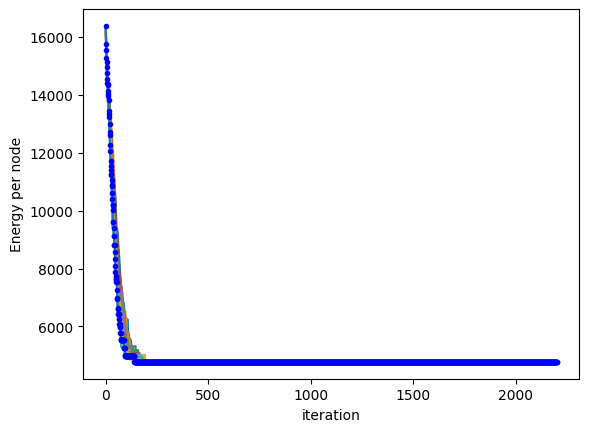

In [19]:
max_step = 8000
x=np.arange( len(energies_pasos[0,0,:max_step]) )
for k_nt in range(0,N_t):
    energies_pasos_temper = energies_pasos[0,k_nt,:max_step] 
    # plt.plot(x[:],energies_pasos_temper[:],'.',color = 'gray',label='%s beta' % tempers[k_nt])
    plt.plot(x[:],energies_pasos_temper[:max_step],'-',label='%s beta' % tempers_loop[k_nt])
    plt.xlabel('iteration')
    plt.ylabel('Energy per node')
# plt.legend()

temper = -1# np.where(tempers == 1)[0][0]
energies_pasos_temper = energies_pasos[0,temper,:max_step] 
plt.plot(x[:],energies_pasos_temper[:max_step],'b.',label='%s beta' % tempers_loop[k_nt])
plt.show()

In [20]:
suma = 0
for i_x in range(Nx):
    node0 = P_store[0,0,-1,0, i_x]
    node1 = P_store[0,0,-1,1, i_x]
    if node0 == node1:
        suma += 1
print(suma/Nx)

1.0


In [21]:
np.where(Energy_store[0,:-1,-1]== np.min(Energy_store[0,:-1,-1]))[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [22]:
## Final energy
Energy_calculada = np.zeros((N_t))
for k_nt in range(N_t):
    Edges_L= K*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL = Edges_sum - Edges_L
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A,P_inv_t[k_nt,:,:])
    Energy_calculada[k_nt] = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
    
print('Energy final:', Energy_t, '/Computed final:', Energy_calculada) 

Energy final: [4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934] /Computed final: [4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934 4775.09060934 4784.50335293 4775.09060934 4775.09060934
 4775.09060934]
